# Training Imitation Learning Model

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers, models

### Check if TensorFlow is Detecting GPU

In [28]:
# Check if TensorFlow can access GPU devices
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print("Found GPU device(s):")
    for device in gpu_devices:
        print(device)
else:
    print("No GPU devices found. TensorFlow will use CPU.")

print("TensorFlow GPU options and configurations:")
print(tf.config.experimental.list_physical_devices('GPU'))
print(tf.config.experimental.get_visible_devices('GPU'))
print(tf.config.experimental.get_memory_growth(gpu_devices[0]))  # Assuming there is at least one GPU device

Found GPU device(s):
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow GPU options and configurations:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
None


### Define the Default Path

In [3]:
# Define root directory and transformations
root_dir = 'data/'

### Remove Stationary Images from Dataset

In [4]:
# Data file path
csv_path = 'data/data.csv'
df = pd.read_csv(csv_path)

# Find images where linear.x is 0
zero_linear_x = df[df['linear_x'] == 0]

# Display the rows to be removed (just to be safe :D)
print(zero_linear_x)

Empty DataFrame
Columns: [image_name, angular_z, linear_x]
Index: []


In [5]:
# Remove these rows from the dataframe
df = df[df['linear_x'] != 0]

# Overwrite the cleaned dataframe to the current CSV
df.to_csv(csv_path, index=False)

# Remove corresponding images from the "data" folder
for image_name in zero_linear_x['image_name']:
    image_path = os.path.join('data', image_name)
    if os.path.exists(image_path):
        os.remove(image_path)
        print(f'Removed: {image_path}')
    else:
        print(f'File not found: {image_path}')

### Create Training Dataset

In [6]:
data = pd.read_csv(csv_path)
images = []
angular_zs = []

for _, row in data.iterrows():
    img_path = os.path.join(root_dir, row['image_name'])
    image = np.array(Image.open(img_path))
    images.append(image)
    angular_zs.append(row['angular_z'])

# Convert list to numpy array
images = np.array(images).astype('float32')
angular_zs = np.array(angular_zs)

# Normalize images
images /= 255

### Shuffle and Unpack Dataset

In [14]:
# Shuffle training set
img_label_set = list(zip(images, angular_zs))
np.random.shuffle(img_label_set)

# Unpack the shuffled dataset back into images and labels
images, angular_zs = zip(*img_label_set)

# Convert them back to numpy arrays
images = np.array(images)
angular_zs = np.array(angular_zs)

### Define CNN Architecture

In [25]:
def create_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(1))
    return model

### Compile and Train the Model

In [26]:
# Create the CNN model
input_shape = images.shape[1:]  # Format: height, width, channels
cnn = create_cnn(input_shape)

# Compile the model
cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Visualize the model
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 44, 128, 16)       448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 22, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 22, 64, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 11, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 11, 32, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 5, 16, 64)       

### Train the Model

In [ ]:
history_cnn = cnn.fit(images, angular_zs, validation_split=0.2, epochs=100, batch_size=16)

### Plot Model Performance

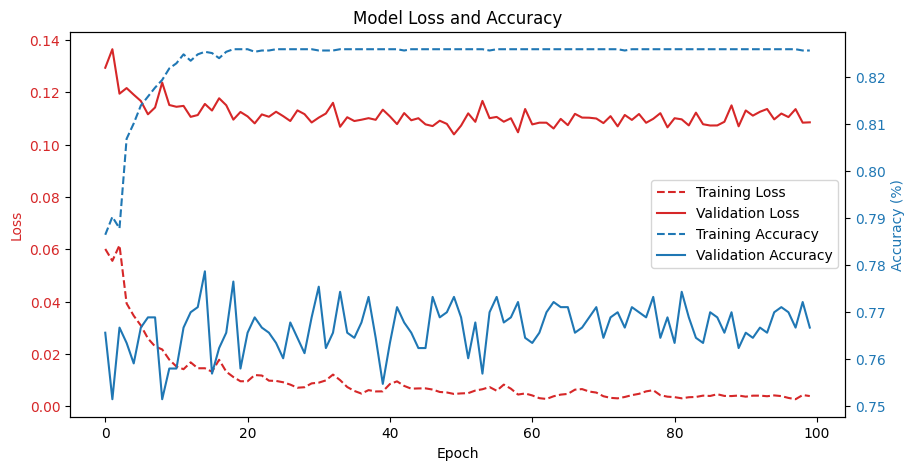

In [19]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot training and validation loss on the first y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(history_cnn.history['loss'], label='Training Loss', color='tab:red', linestyle='--')
ax1.plot(history_cnn.history['val_loss'], label='Validation Loss', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis sharing the same x-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:blue')
ax2.plot(history_cnn.history['accuracy'], label='Training Accuracy', color='tab:blue', linestyle='--')
ax2.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Add legend and title to the plot
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')
plt.title('Model Loss and Accuracy')
plt.show()

### Save the Model

In [20]:
cnn.save('trained_model.keras')